# QMUL GWI: A brief introduction to GW parameter estimation

**Aims of the session**:
1. Understanding how to access and manipulate inteferometric gravitational wave strain data
2. Develop a rudimentry model of Compact Binary Coalescence signals
3. Understand the fundamentals of Bayesian inference (parameter estimation)
4. Apply parameter estimation with out simple model to estimate the properties of an observed signal


## Getting started

To begin, we need to install some packages.

In [ ]:
! pip install gwpy corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 45.0.3 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 45.0.3 which is incompatible.


In [ ]:
from gwpy.timeseries import TimeSeries
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import tqdm

## Inteferometric gravitational wave data

Select some data from the Hanford detector surrounding the first observed signal: GW150914

In [ ]:
trigger_time = 1126259462.4
start_time = round(trigger_time) - 100
end_time = trigger_time + 10
det = 'H1'

data = TimeSeries.fetch_open_data(det, start_time, end_time, cache=True)

The data is a timeseries of the observed strain $h(t)$.

In [ ]:
data

<TimeSeries([3.27993862e-19, 3.59044462e-19, 3.45177340e-19, ...,
             3.30929734e-19, 3.36522250e-19, 3.10090232e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625936e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

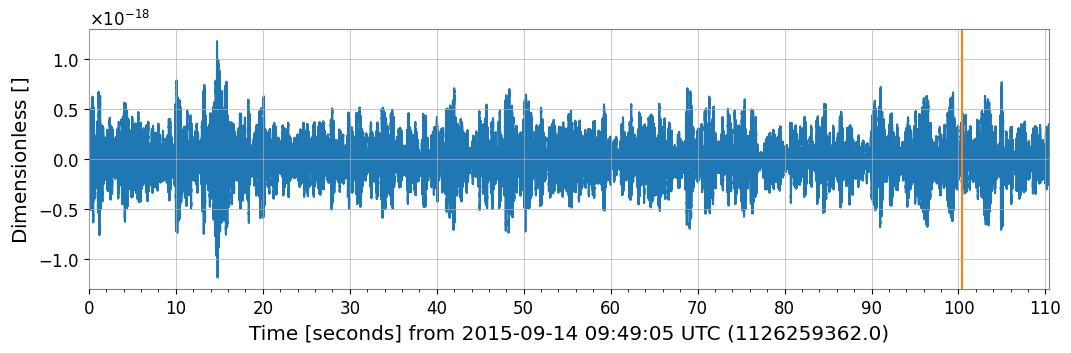

In [ ]:
data.plot()
plt.axvline(trigger_time, color='C1')
plt.show()

We can access information about the timeseries from the `data` instance, for example to get the duration and sampling frequency

In [ ]:
print(f"The data has a duration of {data.duration} and a sampling frequency of {data.sample_rate}")

The data has a duration of 110.39990234375 s and a sampling frequency of 4096.0 Hz


Note that the attibutes `data.duration` etc all have units. If you want just the values, you need to call them as

In [ ]:
data.duration.value

np.float64(110.39990234375)

Finally, we are going to downsample the data to a sampling frequency of 1024 Hz.

In [ ]:
data = data.resample(1024)

### The properties of the noise

The data consists of

$$ h(t) = \textrm{noise} + \textrm{signal} $$

Where we can here assume that the noise is generated by a stationary Gaussian process with a power spectral density (PSD). However, we don't know the PSD and therefore we must estimate it.

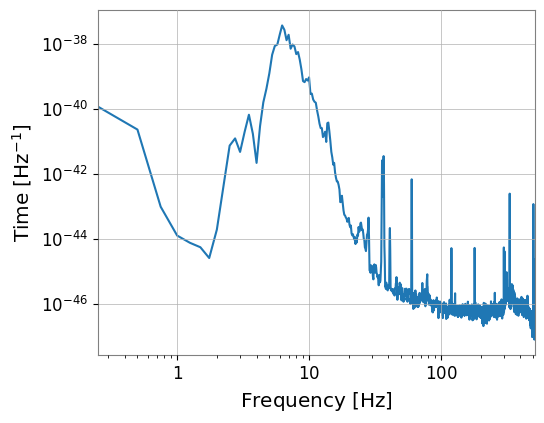

In [ ]:
data_for_psd = data.crop(start=data.t0.value, end=data.t0.value + 64)
psd = data_for_psd.psd(fftlength=4, method="median")
psd.plot()
plt.show()

### Seeing the signal

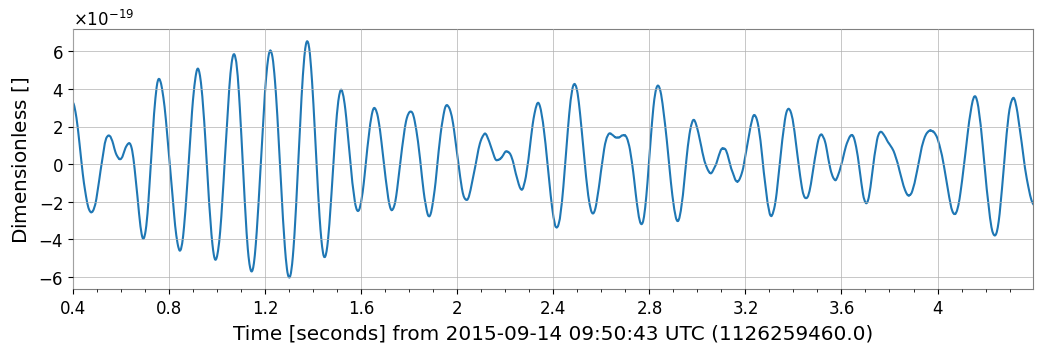

In [ ]:
event_data = data.crop(trigger_time-2, trigger_time+2)
event_data.plot()
plt.show()

In order to "see" the signal, we need to whiten the data

$$ w_j = \sqrt{\frac{2 f_s}{T}} \textrm{IFFT}\left(\frac{\textrm{FFT}(d) }{\sqrt{P}}\right) $$

where $d$ is the strain data in the frequency domain, $P$ is the PSD (note that $\sqrt{P}$ is the amplitude spectral density (ASD)), $T$ is the duration of data, and $f_s$ is the sampling frequency.

There are a few tricks to getting this right. Most importantly you *must* window the data consistently when estimating the PSD and applying the FFT. Here, we are going to use `gwpy` to handle everything for us:

In [ ]:
whitened_event_data = event_data.whiten(asd=np.sqrt(psd))

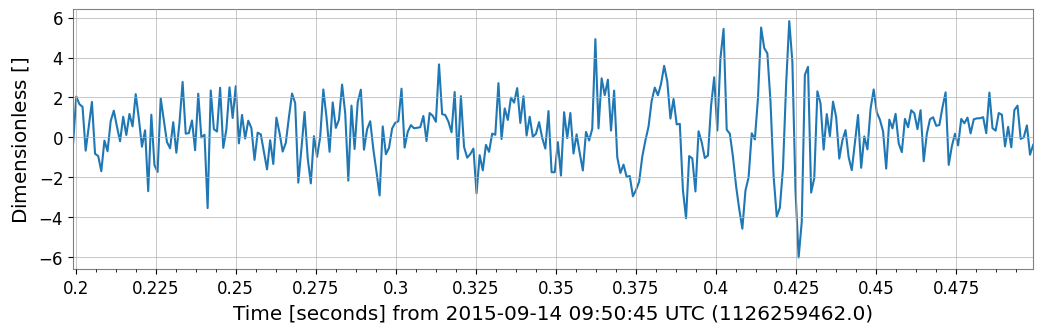

In [ ]:
whitened_event_data.crop(trigger_time-0.2, trigger_time+0.1).plot()
plt.show()

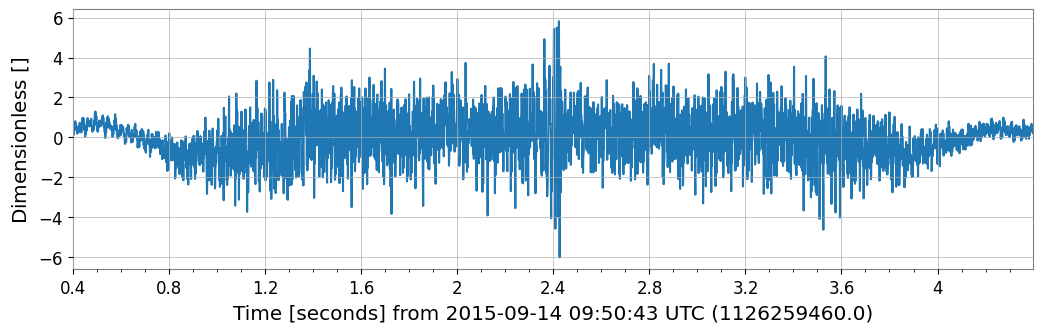

In [ ]:
whitened_event_data.plot()
plt.show()

## A very simple model of a gravitational wave signal

Formally, to model a gravitational-wave signal we need to predict the full detector response

$$ h(t) = F_+ h_+(t) + F_\times h_\times(t) $$

where $F_{+/\times}$ are the detector response to the plus and cross polarization modes of the signal and $h_{+/\times}(t)$ is the time-dependant polarization content of the astrophysical signal as projected onto our line of sight.

**We are going to skip some steps in the interest of time**. Specifically:
- Assume the binary is "face-on" $F_+ = 1$ and $F_\times = 0$ neglecting all information about the source location (e.g. position on the sky)
- Ignore the inclination dependence of the binary
- Assume the binary is non-spinning and in a circular orbit
- Assume only quadrupole radiation
- Assume a simple Newtonian inspiral model

### Stationary phase approximation
First things first, we want to develop the model in the frequency domain, not the time domain. Therefore, we need to calculate
$$ \tilde{h}(f) = \int h(t) e^{-2\pi i ft} dt $$
where $h(t)$ is the time-domain model.
To calculate this, we can make use of the stationary phase approximation (SPA) that applies when the phase is evolving much faster than the frequency. SPA implies that
$$ \tilde{h}(f) \approx \frac{A(t_f)}{\sqrt{\dot{f}(t_f)}} e^{i \Psi(f)} $$
where $A(t_f)$ is the amplitude of the GW signal at the time $t_f$ corresponding to the frequency $f$ (note: SPA assumes a monotonic frequency-time relation) and
$$ \Psi(f) = 2\pi f t_f - \Phi(t_f) - \pi / 4 $$

### Newtonian inspiral
To calculate the phase dependenance $\Phi(t)$, we take Kepler's laws for a circular binary and inserting by hand the energy radiated in GWs, then one arrives at the *chirp formula*:
$$ \dot{f} = \frac{96}{5} \frac{G^{5/3}}{c^5} \pi^{8/3} \mathscr{M}^{5/3} f^{11/3} $$
where
$$ \mathscr{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$
and $m_{1/2}$ are the masses of the two components in the binary.

Then, we need to obtain the phase evolution
$$ \Phi(t) = \phi_c - 2\pi \int_t^{t_c} f(t) dt $$
where $\phi_c$ and $t_c$ are the phase and time of coallescense.
Changing variable to the frequency
$$ \Phi(f) = \phi_c - 2\pi \int_f^{\infty} \frac{f}{\dot{f}} df = \phi_c - 2\pi \int_f^{\infty} \frac{f}{\frac{96}{5} \frac{G^{5/3}}{c^5} \pi^{8/3} \mathscr{M}^{5/3} f^{11/3}} df$$
which yeilds
$$ \Phi(f) = \phi_c - \frac{5}{48} \frac{c^5}{G^{5/3}}\left(\pi \mathscr{M} f\right)^{-5/3} $$

The final ingredient we need it to calculate $t_f$ in the expression for $\Psi(f)$ above. This is done by solving the ODE and inverting to obtain
$$ t(f) = t_c - \frac{5}{256}\frac{1}{\pi^{8/3}}\frac{c^{5}}{G^{5/3}} \mathscr{M}^{-5/3} f^{-8/3} $$

### Calculating $\Psi(f)$

Now, we put all of the phase terms together we get
$$\Psi(f) = 2\pi f t_c - \phi_c - \pi / 4 + \frac{3}{128} \frac{c^5}{G^{5/3}}\left(\pi \mathscr{M} f\right)^{-5/3}  $$

### Calculating the amplitude

Next, we need to calculate the amplitude term $A(t_f)/\sqrt{\dot{f}(t_f)}$.
We have already from Kepler the frequency derivative. Meanwhile the time-domain amplitude is obtained from the Quadrupole formula and yeilds
$$ A(t) = \frac{1}{d_L} \frac{4G}{c^4} \mathscr{M}^{5/3} (\pi f(t))^{2/3} $$
Hence we obtain
$$ \mathscr{A}(f) = \frac{A(t_f)}{\dot{f}(t_f)} = \frac{1}{D}\sqrt{\frac{5}{24}} \pi^{-2/3} \frac{G^{5/6}}{c^{3/2}}\mathscr{M}^{5/6} f^{-7/6} $$


### Putting it all together

Using the SPA aproximation, we can now write down our frequency domain model as

$$ \tilde{h}(f) = \mathscr{A}(f) e^{i \Psi(f)} $$

We will use this directly as our source model (noting that we are neglecting to model the orientation of the binary and position etc).

Finally, we write out a python function for our model

In [ ]:
def strain(f, chirp_mass, luminosity_distance, phi_c, t_c):
    """
    Generate base frequency-domain amplitude of waveform using the leading-order SPA.

    f: frequency array [Hz]
    M_chirp: chirp mass [solar masses]
    D: distance [Mpc]
    """
    # Constants
    G = 6.6743e-11
    c = 299792458
    M_sun = 1.98847e30
    parsec = 3.08567758149e16

    # Conversion
    M_chirp_kg = chirp_mass * M_sun
    D_m = luminosity_distance * 1e6 * parsec

    # Amplitude
    A = 1 / D_m * np.sqrt(5/24) * np.pi ** (-2/3) * G ** (5/6) / c**(3/2) * (M_chirp_kg)**(5/6) * f ** (-7/6)

    Psi = 2 * np.pi * f * t_c - phi_c - np.pi/4 + (3 / 128) * c**5 / G**(5/3) * (np.pi * M_chirp_kg * f) ** (-5/3)

    return A * np.exp(1j * Psi)

We now plot the model prediction alongside the data for comparison, choosing some arbitrary values

In [ ]:
import warnings
warnings.filterwarnings("ignore")

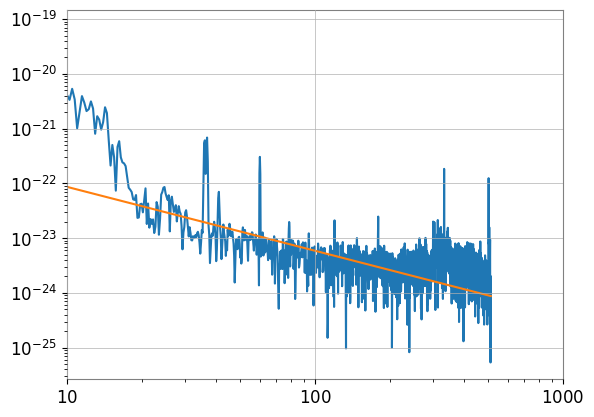

In [ ]:
window = scipy.signal.get_window("hann", len(event_data))
event_data_fft = (window * event_data).fft()

fig, ax = plt.subplots()

ax.loglog(event_data_fft.frequencies, np.abs(event_data_fft.value))
ax.loglog(event_data_fft.frequencies, np.abs(strain(event_data_fft.frequencies.value, 50, 400, 0, 0) / event_data.duration))
ax.set(xlim=(10, 1000))
plt.show()

## Bayesian Inference / Parameter Estimation

Given some model $M$ with associated parameters $\theta$ and a set of data $d$ generated by the model, we want to infer the most probable values of $\theta$ which can be found from Bayes theorem:

$$p(\theta | d, M) = \frac{\mathscr{L}(d; \theta) \pi(\theta | M)}{\mathscr{Z}(d | M)}$$

where $\mathscr{L}(d; \theta)$ is the likelihood, $\pi(\theta | M)$ is the prior distribution, and $\mathscr{Z}(d | M)$ is the normalizing evidence:

$$ \mathscr{Z}(d | M) = \int \mathscr{L}(d; \theta) \pi(\theta | M) d\theta $$

For the purposes of this notebook, we can ignore the evidence and focus only the parameters estimation problem:
$$ p(\theta | d, M) \propto \mathscr{L}(d; \theta) \pi(\theta | M) $$

Moreover, let us assume that $\pi(\theta | M) \propto \mathrm{const}$ so that

$$ p(\theta | d, M) \propto \mathscr{L}(d; \theta) $$

### The Whittle likelihood

For a model that assumes our data consists of stationary Gaussian noise with a known psd $P$ in addition to an astrophysical signal $\mu(\theta)$ the frequency-domain likelihood for the data $d_j$ from the $jth$ frequency bin is given by

$$ \mathscr{L}(\tilde{d}_j | \theta) = \frac{1}{2\pi P_j}\exp\left( -\frac{2}{T}\frac{|\tilde{d}_j - \mu_j(\theta)|^2}{P_j}\right)$$

Since we are already dropping constants and it is best to work in the log of the likelihood, we can simplify this to

$$ \log(\mathscr{L}) \propto -\frac{|\tilde{d}_j - \mu_j(\theta)|^2}{P_j} $$

For our simple model, we have four parameters such that $\theta = [\mathscr{M}, d_L, \phi_c, t_c]$.

Let's write our log likelihood in code:

In [ ]:
def log_likelihood(chirp_mass, luminosity_distance, phi_c, t_c, data, psd):
    f = data.frequencies.value
    # Drop terms in the likelihood below a frequency of 20 Hz
    idxs = np.where(f > 20)
    f = f[idxs]
    psd = psd.value[idxs]
    d = data.value[idxs]
    normalization = f[1] - f[0]

    mu = strain(f, chirp_mass, luminosity_distance, phi_c, t_c) * normalization
    return - np.sum(np.abs(d - mu) ** 2 / psd)

Now we can start by evaluating the likelihood. Let's choose to calculate it along a grid in the chirp mass and leave the values of the other parameters fixed

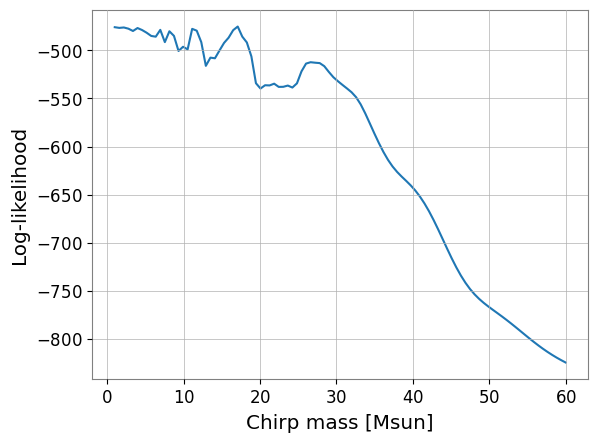

In [ ]:
chirp_masses = np.linspace(1, 60, 100)
logls = []
for mc in chirp_masses:
    logls.append(log_likelihood(mc, 500, 0, 2, event_data_fft, psd))


plt.plot(chirp_masses, logls)
plt.xlabel("Chirp mass [Msun]")
plt.ylabel("Log-likelihood")
plt.show()

In [ ]:
dl = 1000
phi_c = 0
mc_array = np.linspace(10, 100, 200)
tc_array = np.linspace(1.9, 2.1, 200)
logls = np.zeros((len(mc_array), len(tc_array)))
for ii, mc in enumerate(mc_array):
    for jj, tc in enumerate(tc_array):
        logls[ii, jj] = log_likelihood(mc, dl, phi_c, tc, event_data_fft, psd)

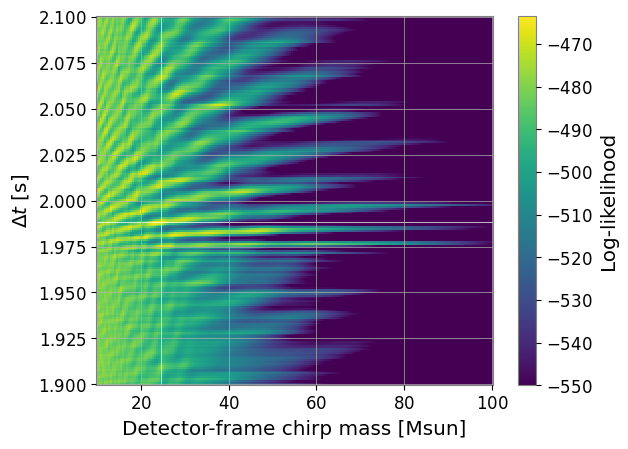

In [ ]:
max_ii, max_jj = np.unravel_index(logls.argmax(), logls.shape)

fig, ax = plt.subplots()

cm = ax.pcolormesh(mc_array, tc_array, logls.T, vmin=-550)
ax.axhline(tc_array[max_jj], color='w', lw=0.5)
ax.axvline(mc_array[max_ii], color='w', lw=0.5)
ax.set(xlabel="Detector-frame chirp mass [Msun]", ylabel="$\Delta t$ [s]")
plt.colorbar(cm, label="Log-likelihood")
plt.show()

### The curse of dimensionality

Above, we have used a gridded approach to numerically evaluate the log likelihood. However, this has a time cost that scales as

$$ T_c = \delta t * n^d $$

where $\delta t$ is the time per likelihood evaluation, $n$ is the number of grid points per axis and $d$ is the number of dimensions.

We can calculate $\delta t$ as so:

In [ ]:
%timeit log_likelihood(50, 500, 0, 2, event_data_fft, psd)

175 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Therefore if we used $n=100$, for our simple four dimensional problem, it would take hundreds of seconds to evaluate:

In [ ]:
175e-6 * 100 ** 4

17500.0

## Approximating distributions with samples

To approximate a distribution, rather than evaluating it on a grid, we can instead try to draw samples from it.

One of the simplest approaches is to use **rejection** sampling. Specifically, to draw samples from a distribution $f(x)$

1. Choose:
   - A proposal distribution $q(x)$ such that $q(x) > 0$ wherever $f(x) > 0$
   - A constant $M \geq \sup_x \left( \frac{f(x)}{q(x)} \right)$

2. Repeat until desired number of samples is obtained:
   1. Sample $x \sim q(x)$
   2. Sample $u \sim \text{Uniform}(0, 1)$
   3. If $u < \frac{f(x)}{M q(x)}$, accept $x$
   4. Else, reject $x$ and repeat

3. Return all accepted samples

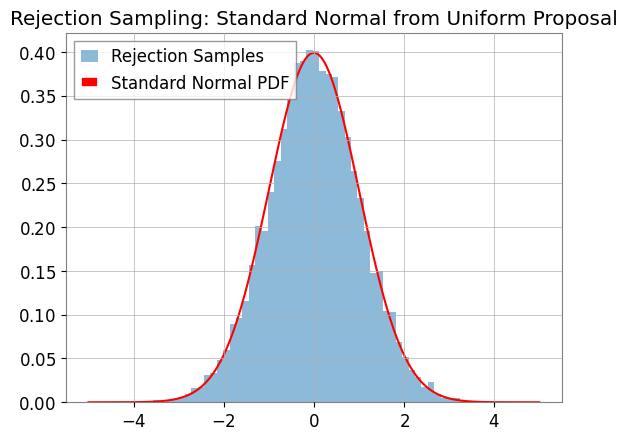

In [ ]:
from scipy.stats import norm

# Target distribution: Standard Normal
def target(x):
    return norm.pdf(x)  # Standard normal PDF

# Proposal distribution: Uniform over [-5, 5]
def proposal_sample():
    return np.random.uniform(-5, 5)

def proposal_pdf(x):
    return 1 / 10 if -5 <= x <= 5 else 0  # Uniform PDF over [-5, 5]

# Find M such that target(x) <= M * proposal_pdf(x) for all x in [-5, 5]
M = max([target(x) / proposal_pdf(x) for x in np.linspace(-5, 5, 1000)])

# Rejection Sampling
samples = []
num_samples = 10000

while len(samples) < num_samples:
    x = proposal_sample()
    u = np.random.uniform(0, 1)
    if u < target(x) / (M * proposal_pdf(x)):
        samples.append(x)

# Plotting the results
x_vals = np.linspace(-5, 5, 1000)
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Rejection Samples')
plt.plot(x_vals, norm.pdf(x_vals), 'r-', label='Standard Normal PDF')
plt.title('Rejection Sampling: Standard Normal from Uniform Proposal')
plt.legend()
plt.show()


Issues with standard rejection sampling:
- Choosing $M$ optimally is difficult
- For complex multi-dimensional distributions, choosing a good generating distribution is nearly as hard as sampling from $f(x)$.

### Markov Chain Monte Carlo

The basic structure of the MCMC algorithm is as follows:

1. Initialize $x^{(0)}$
2. For $t = 1$ to $N$:
   1. Sample $x' \sim q(x' \mid x^{(t-1)})$
   2. Compute  
      $\alpha = \min\left(1, \frac{\pi(x') \, q(x^{(t-1)} \mid x')}{\pi(x^{(t-1)}) \, q(x' \mid x^{(t-1)})}\right)$
   3. Sample $u \sim \text{Uniform}(0, 1)$
   4. If $u < \alpha$, set $x^{(t)} = x'$; else, set $x^{(t)} = x^{(t-1)}$
3. Return $\{x^{(t)}\}_{t=1}^N$

In [ ]:
def run_mcmc(log_likelihood, initial_params, step_sizes, n_samples, data, psd):
    """
    Simple Metropolis-Hastings MCMC sampler using normal proposals.

    Parameters
    ----------
    log_likelihood : function
        Function taking (chirp_mass, luminosity_distance, phi_c, t_c) and returning log-likelihood.
    initial_params : array-like
        Initial guess for parameters: [chirp_mass, distance, phi_c, t_c]
    step_sizes : array-like
        Proposal std devs for Gaussian steps in each parameter.
    n_samples : int
        Total number of MCMC samples to generate.

    Returns
    -------
    samples : ndarray
        Array of shape (n_samples, 4) containing the parameter samples.
    log_probs : ndarray
        Corresponding log-likelihoods of the samples.
    """
    num_params = len(initial_params)
    samples = np.zeros((n_samples, num_params))
    log_probs = np.zeros(n_samples)

    # Start from the initial position
    current_params = np.array(initial_params)
    current_log_prob = log_likelihood(*current_params, data, psd)

    for i in tqdm.tqdm(range(n_samples)):
        # Propose new parameters using Gaussian jumps
        proposal = current_params + np.random.normal(0, step_sizes, num_params)
        proposal_log_prob = log_likelihood(*proposal, data, psd)

        # Acceptance probability
        log_accept_ratio = proposal_log_prob - current_log_prob

        if np.log(np.random.rand()) < log_accept_ratio:
            # Accept the proposal
            current_params = proposal
            current_log_prob = proposal_log_prob

        samples[i] = current_params
        log_probs[i] = current_log_prob

    return samples, log_probs

In [ ]:
# Initial guess and step sizes
initial_params = [40, 1000, 0.0, 2.00]
step_sizes = [1, 100, 0.0, 0.0001]
n_samples = 100000

samples, log_probs = run_mcmc(log_likelihood, initial_params, step_sizes, n_samples, event_data_fft, psd)

100%|██████████| 100000/100000 [00:22<00:00, 4456.86it/s]


Create a trace plot

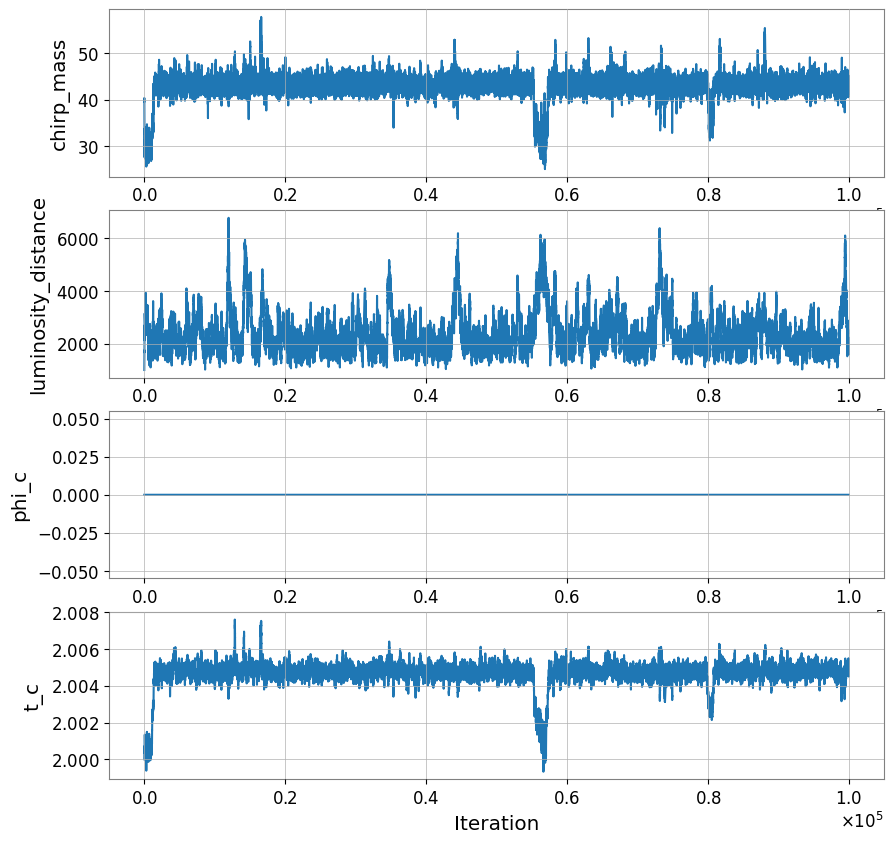

In [ ]:
params = ["chirp_mass", "luminosity_distance", "phi_c", "t_c"]
fig, axes = plt.subplots(nrows=4, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(samples[:, i])
    ax.set_ylabel(params[i])

ax.set_xlabel("Iteration")
plt.show()

### Using the samples

In [ ]:
# Thin the samples
samples = samples[4000:]

The estimated posterior distribution of the chirp mass

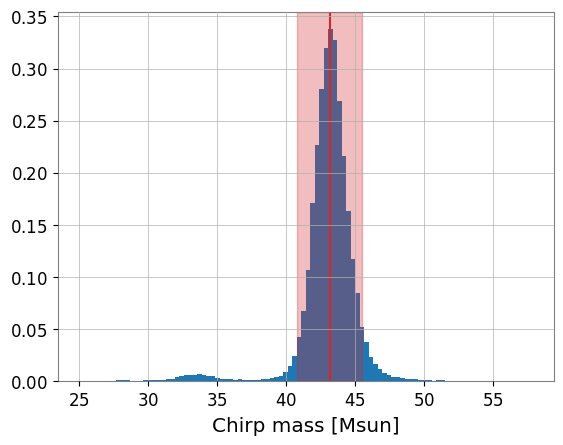

In [ ]:
mc_samples = samples[:, 0]

fig, ax = plt.subplots()
ax.hist(mc_samples, bins=100, density=True)
ax.axvline(np.median(mc_samples), color="C3")
ax.axvspan(np.quantile(mc_samples, 0.05), np.quantile(mc_samples, 0.95), color="C3", alpha=0.3)
ax.set_xlabel("Chirp mass [Msun]")
plt.show()

Or using a so-called corner plot

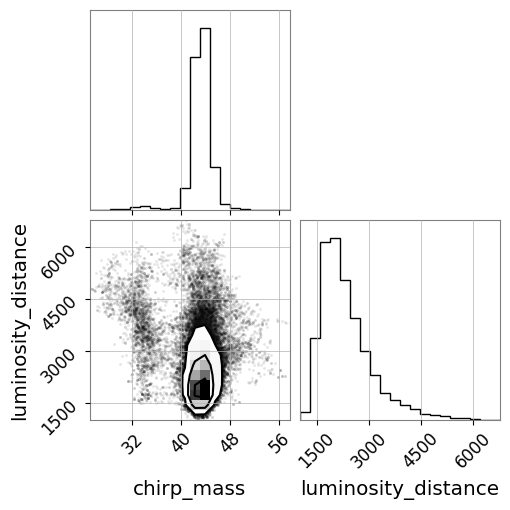

In [ ]:
import corner
fig = corner.corner(samples[:, :2], labels=params)
plt.show()

## Overview/conclusion

* We have done a brief tour of how to handle GW data, model signals, and estimate the properties of signals observed in the data.
* I do not guarantee that everything in this notebook is correct (it has not been well vetted). So take it as a guide.
* I have skipped many important aspects, so read carefully better and more involved tutorials if you want to do science

## Useful resources to follow up

- GWOSC [Open Data Workshops](https://gwosc.org/workshops/) and the related [GitHub directory](https://github.com/gw-odw)
- I have a set of notes from a course "Analysing Gravitational Waves", please contact me and I can share them